<a href="https://colab.research.google.com/github/Giwabestie/NeoGPS/blob/master/Optimus%20Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the Dataset from Kaggle

In [1]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'energy-consumption-generation-prices-and-weather:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F376847%2F731588%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240410%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240410T224307Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D9adf69f6a975ca7fe6bb1503e20ce3ec3ad873f7745704f6fc9c4b0e74180f72f2076efc41f59cfe952cf1e61a47dd16acc2c6bb76d7fe564b65f19650aa1402abad0b72061fc0f35e7b07fd827230c56c5e97c33cc2d595502a60d11fb44be617c71c9c8d81fffc4fd1e00d9fd606b8384de3c6932cd397f86b5e8b1eff3be46e12bad0090f8cce6eba7252ecea21634284e226d2dd95c5f0edef61004b2feaa1026b94b2dc73d31d32b4a7bc6ba2b6e137a7fbd61a76b944ac2c80b485deddc4726b7dbe2d37f82bcf50db2525aea884ff1fd183600b2992401972b592aeb2c4c2d6bbca67b0bbd3b094407656d7be65d4ec43b4846c4dfbc1e5c6167160d3'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 3996743 bytes downloaded
Downloaded and uncompressed: energy-consumption-generation-prices-and-weather
Data source import complete.


Get the Dataset File Path Link

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv
/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv


Import all packages

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

## About the dataset
This dataset contains 4 years of electrical consumption, generation, pricing, and weather data for Spain. Consumption and generation data was retrieved from ENTSOE a public portal for Transmission Service Operator (TSO) data. Settlement prices were obtained from the Spanish TSO Red Electric España. Weather data was purchased as part of a personal project from the Open Weather API for the 5 largest cities in Spain and made public on **Kaggle**.

The dataset is unique because it contains hourly data for electrical consumption and the respective forecasts by the TSO for consumption and pricing. This allows prospective forecasts to be benchmarked against the current state of the art forecasts being used in industry.

Import the Datasets

In [4]:
df = pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/energy_dataset.csv')
df.head()


,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [5]:
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [6]:
df1=pd.read_csv('/kaggle/input/energy-consumption-generation-prices-and-weather/weather_features.csv')
df1.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [7]:
df1.columns

Index(['dt_iso', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h',
       'clouds_all', 'weather_id', 'weather_main', 'weather_description',
       'weather_icon'],
      dtype='object')

# Data Manipulation

1. Exploring Energy Dataset

Drop unncessary data from energy dataset

In [8]:
columns_to_drop = ['generation fossil brown coal/lignite',
                   'generation fossil coal-derived gas',
                   'generation fossil gas',
                   'generation fossil hard coal',
                   'generation fossil oil',
                   'generation fossil oil shale',
                   'generation fossil peat',
                   'generation hydro pumped storage aggregated',
                   'generation hydro run-of-river and poundage',
                   'generation hydro water reservoir',
                   'generation biomass',
                   'generation marine',
                   'generation other',
                   'generation nuclear',
                   'generation hydro pumped storage consumption',
                   'generation waste',
                   'generation wind offshore',
                   'generation geothermal',
                   'forecast solar day ahead',
                   'total load forecast',
                   'price day ahead',
                   'forecast wind offshore eday ahead',
                   'forecast wind onshore day ahead']


# Drop the specified columns
energy = df.drop(columns=columns_to_drop)
energy.head()


,time,generation other renewable,generation solar,generation wind onshore,total load actual,price actual
0,2015-01-01 00:00:00+01:00,73.0,49.0,6378.0,25385.0,65.41
1,2015-01-01 01:00:00+01:00,71.0,50.0,5890.0,24382.0,64.92
2,2015-01-01 02:00:00+01:00,73.0,50.0,5461.0,22734.0,64.48
3,2015-01-01 03:00:00+01:00,75.0,50.0,5238.0,21286.0,59.32
4,2015-01-01 04:00:00+01:00,74.0,42.0,4935.0,20264.0,56.04


Rename the Energy Dataset

In [9]:
energy.columns

Index(['time', 'generation other renewable', 'generation solar',
       'generation wind onshore', 'total load actual', 'price actual'],
      dtype='object')

In [10]:
new_column_names = {
    'generation other renewable': 'other renewable (MW)',
    'generation solar': 'solar power (MW)',
    'generation wind onshore': 'wind power (MW)',
    'total load actual': 'total actual load (MW)',
    'price actual': 'actual price (£/MWh)'
}

# Rename the columns
energy = energy.rename(columns=new_column_names)
energy.head()

,time,other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
0,2015-01-01 00:00:00+01:00,73.0,49.0,6378.0,25385.0,65.41
1,2015-01-01 01:00:00+01:00,71.0,50.0,5890.0,24382.0,64.92
2,2015-01-01 02:00:00+01:00,73.0,50.0,5461.0,22734.0,64.48
3,2015-01-01 03:00:00+01:00,75.0,50.0,5238.0,21286.0,59.32
4,2015-01-01 04:00:00+01:00,74.0,42.0,4935.0,20264.0,56.04


2. Exploring Weather Features Dataset

Drop unnecesssay columns

In [11]:
drop_weather_columns = ['temp_min','temp_max', 'city_name','rain_3h', 'snow_3h','weather_id', 'weather_icon','weather_description', 'weather_main']
# Drop the specified columns
weather = df1.drop(columns=drop_weather_columns)
weather.head()

,dt_iso,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all
0,2015-01-01 00:00:00+01:00,270.475,1001,77,1,62,0.0,0
1,2015-01-01 01:00:00+01:00,270.475,1001,77,1,62,0.0,0
2,2015-01-01 02:00:00+01:00,269.686,1002,78,0,23,0.0,0
3,2015-01-01 03:00:00+01:00,269.686,1002,78,0,23,0.0,0
4,2015-01-01 04:00:00+01:00,269.686,1002,78,0,23,0.0,0


Rename the columns

In [12]:
column_names = {
    'dt_iso': 'time',
    'temp': 'temperature (K)',
    'wind_speed': 'wind speed (m/s)',
    'wind_deg': 'wind direction (°)',
    'clouds_all': 'clouds_all (%)',
    'rain_1h': 'rain_1h (mm)',
    'pressure':'pressure (hPa)',
    'humidity':'humidity (%)'
}

# Rename the columns
weather = weather.rename(columns=column_names)
weather.head()

,time,temperature (K),pressure (hPa),humidity (%),wind speed (m/s),wind direction (°),rain_1h (mm),clouds_all (%)
0,2015-01-01 00:00:00+01:00,270.475,1001,77,1,62,0.0,0
1,2015-01-01 01:00:00+01:00,270.475,1001,77,1,62,0.0,0
2,2015-01-01 02:00:00+01:00,269.686,1002,78,0,23,0.0,0
3,2015-01-01 03:00:00+01:00,269.686,1002,78,0,23,0.0,0
4,2015-01-01 04:00:00+01:00,269.686,1002,78,0,23,0.0,0


Merge the Energy and Weather Features Dataset

In [13]:
data = pd.merge(weather, energy, on='time')
data.head()

,time,temperature (K),pressure (hPa),humidity (%),wind speed (m/s),wind direction (°),rain_1h (mm),clouds_all (%),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
0,2015-01-01 00:00:00+01:00,270.475000,1001,77,1,62,0.0,0,73.0,49.0,6378.0,25385.0,65.41
1,2015-01-01 00:00:00+01:00,267.325000,971,63,1,309,0.0,0,73.0,49.0,6378.0,25385.0,65.41
2,2015-01-01 00:00:00+01:00,269.657312,1036,97,0,226,0.0,0,73.0,49.0,6378.0,25385.0,65.41
3,2015-01-01 00:00:00+01:00,281.625000,1035,100,7,58,0.0,0,73.0,49.0,6378.0,25385.0,65.41
4,2015-01-01 00:00:00+01:00,273.375000,1039,75,1,21,0.0,0,73.0,49.0,6378.0,25385.0,65.41


In [14]:
print(data.shape)
data.columns

(178396, 13)


Index(['time', 'temperature (K)', 'pressure (hPa)', 'humidity (%)',
       'wind speed (m/s)', 'wind direction (°)', 'rain_1h (mm)',
       'clouds_all (%)', 'other renewable (MW)', 'solar power (MW)',
       'wind power (MW)', 'total actual load (MW)', 'actual price (£/MWh)'],
      dtype='object')

In [15]:
# Convert 'time' column to datetime format with timezone information
data['time'] = pd.to_datetime(data['time'], utc=True)

# Remove timezone information
data['time'] = data['time'].dt.tz_convert(None)
print(data['time'].dtype)
data.head()

datetime64[ns]


,time,temperature (K),pressure (hPa),humidity (%),wind speed (m/s),wind direction (°),rain_1h (mm),clouds_all (%),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
0,2014-12-31 23:00:00,270.475000,1001,77,1,62,0.0,0,73.0,49.0,6378.0,25385.0,65.41
1,2014-12-31 23:00:00,267.325000,971,63,1,309,0.0,0,73.0,49.0,6378.0,25385.0,65.41
2,2014-12-31 23:00:00,269.657312,1036,97,0,226,0.0,0,73.0,49.0,6378.0,25385.0,65.41
3,2014-12-31 23:00:00,281.625000,1035,100,7,58,0.0,0,73.0,49.0,6378.0,25385.0,65.41
4,2014-12-31 23:00:00,273.375000,1039,75,1,21,0.0,0,73.0,49.0,6378.0,25385.0,65.41


Transform the 'Time' feature

In [16]:
# Convert datetime column to numerical features and data type int64
def convert_datetime_features(data):
    data['hour'] = data['time'].dt.hour.astype('int64')
    data['day'] = data['time'].dt.day.astype('int64')
    data['month'] = data['time'].dt.month.astype('int64')
    data['year'] = data['time'].dt.year.astype('int64')
    return data

# Apply the conversion function to cleaned_data
data = convert_datetime_features(data)

# Drop the 'time' column as we have extracted the features we need
data = data.drop(columns=['time'])

# Print the first few rows to check the changes
data.head()


,temperature (K),pressure (hPa),humidity (%),wind speed (m/s),wind direction (°),rain_1h (mm),clouds_all (%),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh),hour,day,month,year
0,270.475000,1001,77,1,62,0.0,0,73.0,49.0,6378.0,25385.0,65.41,23,31,12,2014
1,267.325000,971,63,1,309,0.0,0,73.0,49.0,6378.0,25385.0,65.41,23,31,12,2014
2,269.657312,1036,97,0,226,0.0,0,73.0,49.0,6378.0,25385.0,65.41,23,31,12,2014
3,281.625000,1035,100,7,58,0.0,0,73.0,49.0,6378.0,25385.0,65.41,23,31,12,2014
4,273.375000,1039,75,1,21,0.0,0,73.0,49.0,6378.0,25385.0,65.41,23,31,12,2014


Rearrange the Columns

In [17]:
# Define the columns you want to reorder
columns_to_move = ['hour', 'day', 'month', 'year']

# Move the specified columns to the front
columns = data.columns.tolist()  # Get the current list of columns
for col in columns_to_move:
    if col in columns:
        # Remove the column from its current position
        columns.remove(col)
        # Insert the column at the front of the list
        columns.insert(0, col)

# Reorder the DataFrame columns
data = data[columns]

# Display the reordered DataFrame
data.head()


,year,month,day,hour,temperature (K),pressure (hPa),humidity (%),wind speed (m/s),wind direction (°),rain_1h (mm),clouds_all (%),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
0,2014,12,31,23,270.475000,1001,77,1,62,0.0,0,73.0,49.0,6378.0,25385.0,65.41
1,2014,12,31,23,267.325000,971,63,1,309,0.0,0,73.0,49.0,6378.0,25385.0,65.41
2,2014,12,31,23,269.657312,1036,97,0,226,0.0,0,73.0,49.0,6378.0,25385.0,65.41
3,2014,12,31,23,281.625000,1035,100,7,58,0.0,0,73.0,49.0,6378.0,25385.0,65.41
4,2014,12,31,23,273.375000,1039,75,1,21,0.0,0,73.0,49.0,6378.0,25385.0,65.41


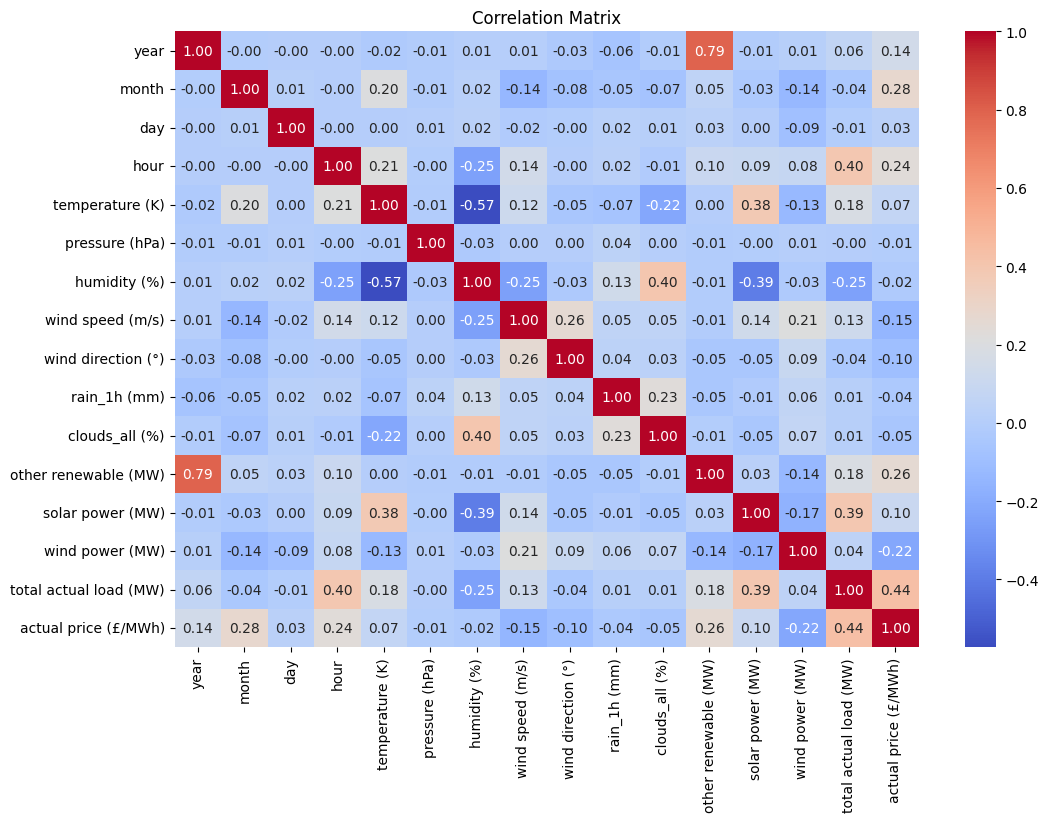

In [18]:
import seaborn as sns
# Select the features and the target variable
features = ['year',	'month',	'day',	'hour', 'temperature (K)', 'pressure (hPa)', 'humidity (%)',
            'wind speed (m/s)', 'wind direction (°)', 'rain_1h (mm)',
            'clouds_all (%)', 'other renewable (MW)', 'solar power (MW)',
            'wind power (MW)', 'total actual load (MW)']

target = 'actual price (£/MWh)'

# Calculate the correlation matrix for the features and the target variable
correlation_matrix = data[features + [target]].corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Matrix')
plt.show()


Findings:
Pressure, rain_1h and cloud_all columns are insignificant. Hence, these columns will be dropped.

In [19]:
drop_data_columns = ['pressure (hPa)', 'rain_1h (mm)',	'clouds_all (%)']
# Drop the specified columns
data = data.drop(columns=drop_data_columns)
data.head()

,year,month,day,hour,temperature (K),humidity (%),wind speed (m/s),wind direction (°),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
0,2014,12,31,23,270.475000,77,1,62,73.0,49.0,6378.0,25385.0,65.41
1,2014,12,31,23,267.325000,63,1,309,73.0,49.0,6378.0,25385.0,65.41
2,2014,12,31,23,269.657312,97,0,226,73.0,49.0,6378.0,25385.0,65.41
3,2014,12,31,23,281.625000,100,7,58,73.0,49.0,6378.0,25385.0,65.41
4,2014,12,31,23,273.375000,75,1,21,73.0,49.0,6378.0,25385.0,65.41


In [20]:
print(data.shape)

(178396, 13)


## Data Cleaning

Check for Missing Values

In [21]:
# Check missing values
missing_values = data.isnull().sum()
print("Missing values before cleaning:\n", missing_values)
# Check the number of rows before removing missing values
rows_before = len(data)
print("Number of rows before removing missing values:", rows_before)

Missing values before cleaning:
 year                        0
month                       0
day                         0
hour                        0
temperature (K)             0
humidity (%)                0
wind speed (m/s)            0
wind direction (°)          0
other renewable (MW)       90
solar power (MW)           90
wind power (MW)            90
total actual load (MW)    180
actual price (£/MWh)        0
dtype: int64
Number of rows before removing missing values: 178396


Remove Missing values

In [22]:
# Remove rows with missing values
cleaned_df = data.dropna()

# Check missing values after cleaning
missing_values_after = cleaned_df.isnull().sum()
print("Missing values after cleaning:\n", missing_values_after)
# Check the number of rows after removing missing values
rows_after = len(cleaned_df)

print("Number of rows after removing missing values:", rows_after)

Missing values after cleaning:
 year                      0
month                     0
day                       0
hour                      0
temperature (K)           0
humidity (%)              0
wind speed (m/s)          0
wind direction (°)        0
other renewable (MW)      0
solar power (MW)          0
wind power (MW)           0
total actual load (MW)    0
actual price (£/MWh)      0
dtype: int64
Number of rows after removing missing values: 178191


Data Exploration to Check Outliers

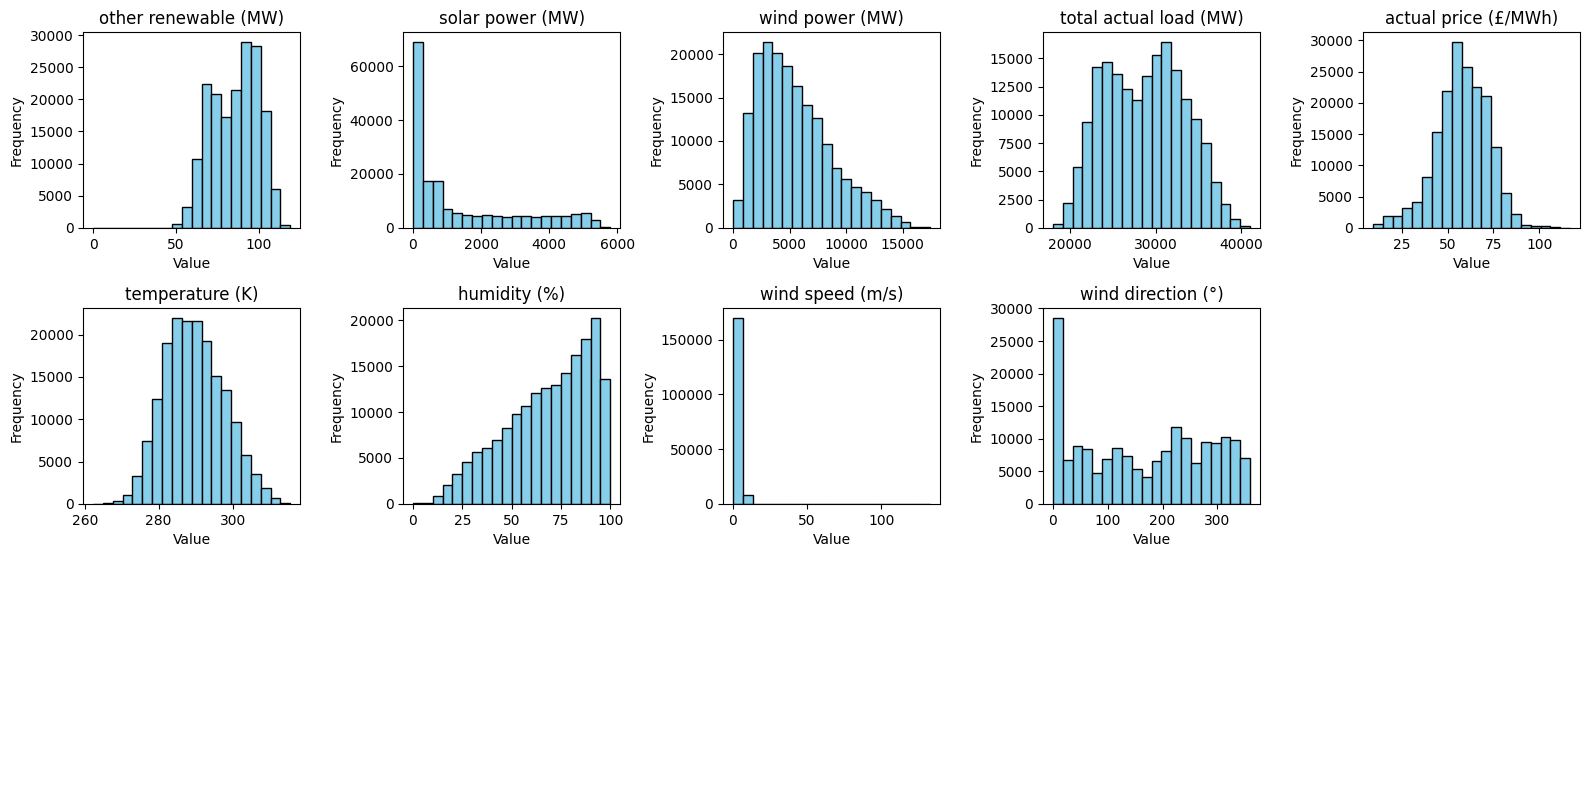

In [23]:
numerical_columns = [ 'other renewable (MW)','solar power (MW)', 'wind power (MW)', 'total actual load (MW)',
                     'actual price (£/MWh)', 'temperature (K)','humidity (%)', 'wind speed (m/s)', 'wind direction (°)']

# Create a figure and axis objects
fig, axes = plt.subplots(3, 5, figsize=(16, 8))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Plot histograms for each numerical column
for i, column in enumerate(numerical_columns):
    axes[i].hist(data[column].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Hide empty subplots
for i in range(len(numerical_columns), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


**Findings**:
Outliers were detected in the following columns with the respective range of values:
1. Wind speed (> 30)
2. Other renewables (<40)


Remove Outliers

In [24]:
# Keep all the following data
cleaned_data = data[data['wind speed (m/s)'] <= 30 & (data['other renewable (MW)'] > 40)]

# Number of rows before and after cleaning
rows_before = len(data)
rows_after = len(cleaned_data)
# Displaying number of rows before and after cleaning
print("Number of rows before cleaning:", rows_before)
print("Number of rows after cleaning:", rows_after)


cleaned_data.head()

Number of rows before cleaning: 178396
Number of rows after cleaning: 18490


,year,month,day,hour,temperature (K),humidity (%),wind speed (m/s),wind direction (°),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
2,2014,12,31,23,269.657312,97,0,226,73.0,49.0,6378.0,25385.0,65.41
7,2015,1,1,0,269.763500,97,0,229,71.0,50.0,5890.0,24382.0,64.92
10,2015,1,1,1,269.686000,78,0,23,73.0,50.0,5461.0,22734.0,64.48
15,2015,1,1,2,269.686000,78,0,23,75.0,50.0,5238.0,21286.0,59.32
20,2015,1,1,3,269.686000,78,0,23,74.0,42.0,4935.0,20264.0,56.04


In [25]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18490 entries, 2 to 178373
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    18490 non-null  int64  
 1   month                   18490 non-null  int64  
 2   day                     18490 non-null  int64  
 3   hour                    18490 non-null  int64  
 4   temperature (K)         18490 non-null  float64
 5   humidity (%)            18490 non-null  int64  
 6   wind speed (m/s)        18490 non-null  int64  
 7   wind direction (°)      18490 non-null  int64  
 8   other renewable (MW)    18489 non-null  float64
 9   solar power (MW)        18489 non-null  float64
 10  wind power (MW)         18489 non-null  float64
 11  total actual load (MW)  18481 non-null  float64
 12  actual price (£/MWh)    18490 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.0 MB


Convert float columns to integer data type

In [26]:
# Convert float columns to integer data type
columns_to_convert = ['other renewable (MW)', 'solar power (MW)', 'wind power (MW)',
                      'total actual load (MW)']

# Number of rows before removing NaN values
rows_before2 = len(cleaned_data)

# Drop rows containing NaN values
cleaned_data = cleaned_data.dropna(subset=columns_to_convert)

# Number of rows after removing NaN values
rows_after2 = len(cleaned_data)

# Convert float columns to integer data type
cleaned_data[columns_to_convert] = cleaned_data[columns_to_convert].astype(int)

# Print the number of rows before and after removing NaN values
print("Number of rows before removing NaN values:", rows_before2)
print("Number of rows after removing NaN values:", rows_after2)

cleaned_data.info()

Number of rows before removing NaN values: 18490
Number of rows after removing NaN values: 18480
<class 'pandas.core.frame.DataFrame'>
Index: 18480 entries, 2 to 178373
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    18480 non-null  int64  
 1   month                   18480 non-null  int64  
 2   day                     18480 non-null  int64  
 3   hour                    18480 non-null  int64  
 4   temperature (K)         18480 non-null  float64
 5   humidity (%)            18480 non-null  int64  
 6   wind speed (m/s)        18480 non-null  int64  
 7   wind direction (°)      18480 non-null  int64  
 8   other renewable (MW)    18480 non-null  int64  
 9   solar power (MW)        18480 non-null  int64  
 10  wind power (MW)         18480 non-null  int64  
 11  total actual load (MW)  18480 non-null  int64  
 12  actual price (£/MWh)    18480 non-null  float64
dty

<ipython-input-26-59a33b626cc6>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data[columns_to_convert] = cleaned_data[columns_to_convert].astype(int)


In [27]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18480 entries, 2 to 178373
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    18480 non-null  int64  
 1   month                   18480 non-null  int64  
 2   day                     18480 non-null  int64  
 3   hour                    18480 non-null  int64  
 4   temperature (K)         18480 non-null  float64
 5   humidity (%)            18480 non-null  int64  
 6   wind speed (m/s)        18480 non-null  int64  
 7   wind direction (°)      18480 non-null  int64  
 8   other renewable (MW)    18480 non-null  int64  
 9   solar power (MW)        18480 non-null  int64  
 10  wind power (MW)         18480 non-null  int64  
 11  total actual load (MW)  18480 non-null  int64  
 12  actual price (£/MWh)    18480 non-null  float64
dtypes: float64(2), int64(11)
memory usage: 2.0 MB


Get Statsitical info about the Dataset

In [28]:
cleaned_data.describe()

,year,month,day,hour,temperature (K),humidity (%),wind speed (m/s),wind direction (°),other renewable (MW),solar power (MW),wind power (MW),total actual load (MW),actual price (£/MWh)
count,18480.000000,18480.000000,18480.000000,18480.000000,18480.000000,18480.000000,18480.0,18480.000000,18480.000000,18480.000000,18480.000000,18480.000000,18480.000000
mean,2016.502327,7.059686,15.973106,10.006656,288.034939,77.519156,0.0,81.268290,86.135660,1114.784957,4847.118290,27885.073214,58.484686
std,1.019532,3.437325,8.864999,7.319161,7.327364,19.198208,0.0,113.924558,13.634263,1516.642452,2939.314305,4606.962710,13.054424
min,2014.000000,1.000000,1.000000,0.000000,265.442000,0.000000,0.0,0.000000,4.000000,2.000000,234.000000,18178.000000,9.330000
25%,2016.000000,4.000000,8.000000,4.000000,282.650000,67.000000,0.0,0.000000,74.000000,53.000000,2577.000000,24019.000000,50.160000
50%,2017.000000,7.000000,16.000000,8.000000,288.080000,82.000000,0.0,0.000000,88.000000,388.000000,4288.500000,27388.000000,57.900000
75%,2017.000000,10.000000,24.000000,17.000000,293.010000,93.000000,0.0,156.000000,97.000000,1607.250000,6540.250000,31532.000000,67.530000
max,2018.000000,12.000000,31.000000,23.000000,315.600000,100.000000,0.0,360.000000,119.000000,5682.000000,16022.000000,40900.000000,110.630000


In [29]:
cleaned_data.shape

(18480, 13)

## Machine Learning Process Begins

Split the dataset Features (X) and Target (y)

In [30]:
# Splitting the data into features and target variable
X = cleaned_data.drop(columns=['actual price (£/MWh)'])
y = cleaned_data['actual price (£/MWh)']

Splitting the data into training and testing sets

In [31]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Normalise the dataset

In [32]:
# Normalize the numerical features using MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest Model Training



In [33]:
# Define the hyperparameters for the random forest model
rf_model = RandomForestRegressor(
    n_estimators=100,  # Number of trees in the forest
    max_depth=10,  # Maximum depth of each tree
    min_samples_split=2,  # Minimum number of samples required to split an internal node
    min_samples_leaf=1,  # Minimum number of samples required to be at a leaf node
    max_features='sqrt',  # Number of features to consider when looking for the best split
    random_state=0  # Random state for reproducibility
)

In [34]:
# Train the Random Forest model
rf_model.fit(X_train_scaled, y_train)


RandomForestRegressor(max_depth=10, max_features='sqrt', random_state=0)

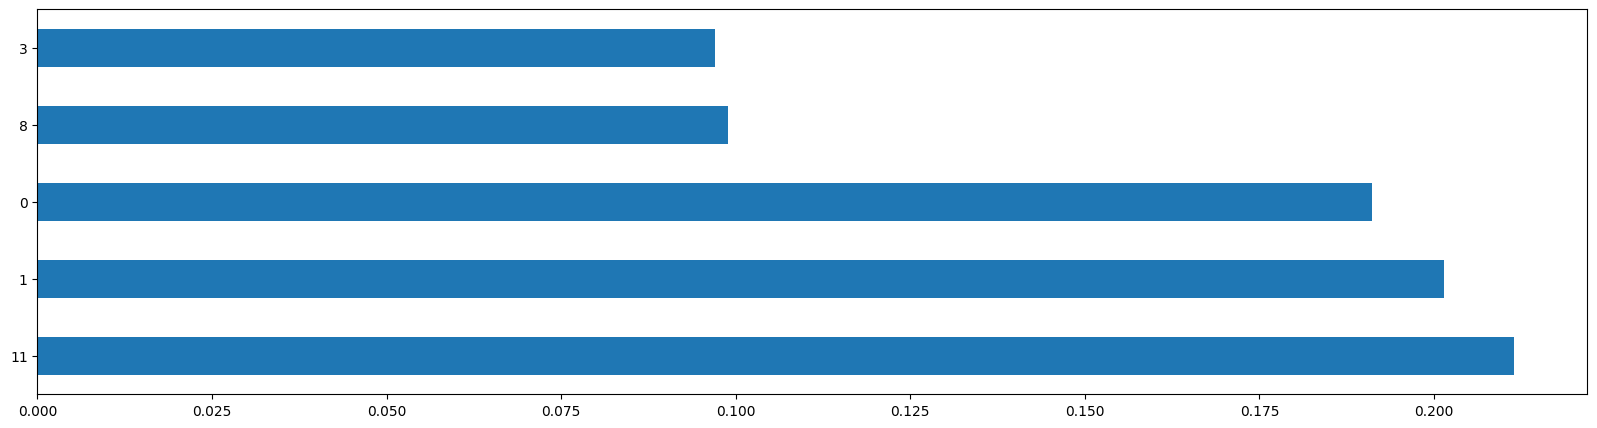

In [37]:
#Plot graph of feature importances for better visualization
X_train_scaled = pd.DataFrame(X_train_scaled)
feat_importance = pd.Series(rf_model.feature_importances_, index= X_train_scaled.columns)
feat_importance.nlargest(5).plot(kind='barh', figsize= (20,5))
plt.show()

In [38]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

In [39]:
# Evaluate the model performance
#mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # Calculate RMSE from MSE
r2 = r2_score(y_test, y_pred)

#print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)

Mean Absolute Error (MAE): 4.076477472291648
Root Mean Squared Error (RMSE): 5.551031036659283
R-squared (R2): 0.8166648166753785


In [40]:
# Convert evaluation metrics to percentage
total_var = y_test.var()
#mse_percent = (mse / total_var) * 100
mae_percent = (mae / total_var) * 100
rmse_percent = (rmse / total_var) * 100
r2_percent = (r2 / total_var) * 100

#print("Mean Squared Error (MSE) (%):", mse_percent)
print("Mean Absolute Error (MAE) (%):", mae_percent)
print("Root Mean Squared Error (RMSE) (%):", rmse_percent)
print("R-squared (R2) (%):", r2_percent)

Mean Absolute Error (MAE) (%): 2.4247447790832197
Root Mean Squared Error (RMSE) (%): 3.301829487874461
R-squared (R2) (%): 0.4857634474750034


Plot the Actual Vs Predicted Values

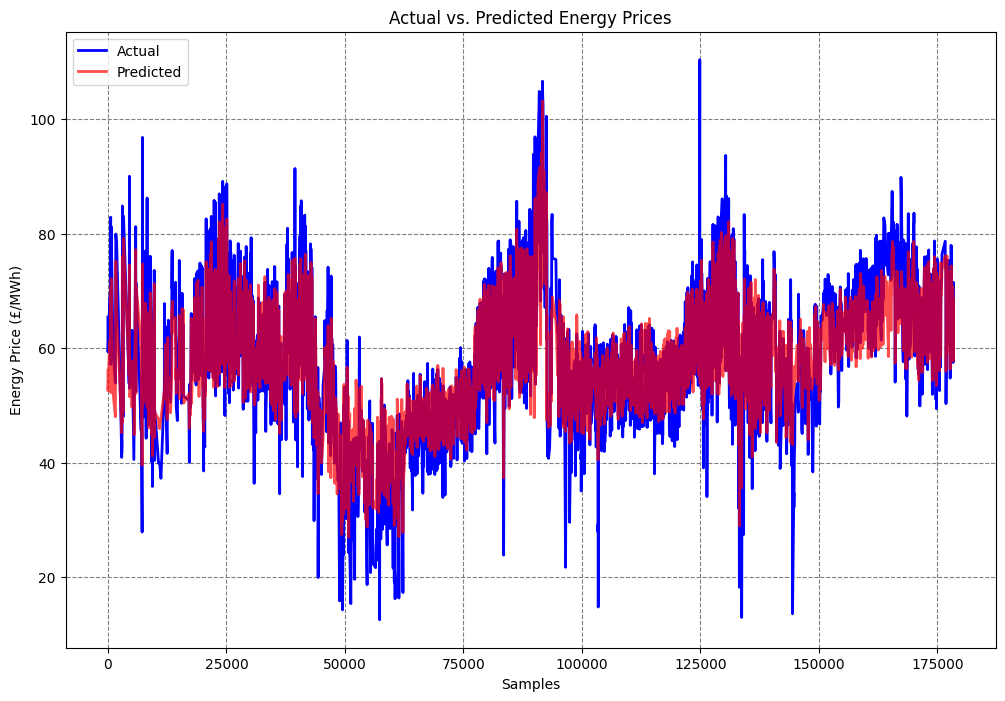

In [45]:


# Sort y_test and y_pred according to the indices of y_test
y_test_sorted = y_test.sort_index()
y_pred_sorted = y_pred[np.argsort(y_test.index)]

# Visualize actual vs. predicted values
plt.figure(figsize=(12, 8))

# Plot actual values
plt.plot(y_test_sorted.index, y_test_sorted, label='Actual', color='blue', linewidth=2)

# Plot predicted values
plt.plot(y_test_sorted.index, y_pred_sorted, label='Predicted', color='red', alpha=0.7, linewidth=2)

# Set plot title and axis labels
plt.title('Actual vs. Predicted Energy Prices')
plt.xlabel('Samples')
plt.ylabel('Energy Price (£/MWh)')

# Add legend to distinguish between the lines
plt.legend(loc='upper left')

# Add grid lines for better readability
plt.grid(True, linestyle='--', color='gray')

# Display the plot
plt.show()


Model Deployment Process

In [46]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00


In [47]:
import pickle
import streamlit as st

In [48]:
#Load the saved model
file = open('random_forest_model.pkl', 'wb')
pickle.dump(rf_model,file)

Code for Deploying Model On Streamlit Uisng Visual Studio Code

In [ ]:
#Load the saved model
model= pickle.load(open('C:/Users/User/Documents/ML Project/Optimus Hackathon/random_forest_model.pkl', 'rb'))

def main():
  st.title('Energy Consumption Price')

  #Input Variables
  year= st.text_input('Year')
  month= st.text_input('Month (In Number)')
  day= st.text_input('Day of the month(In Nunber)')
  hour= st.text_input('Hour of the day (In number)')
  temp =st.text_input('Temperature (K)')
  hum= st.text_input('Humidity (between 0-100%)')
  wind_speed= st.text_input('Wind speed (between 1-30m/s)')
  wind_direction= st.text_input('Wind direction (between 0-360°)')
  others_ren = st.text_input('Other renewable (MW)')
  solar= st.text_input('Solar power (MW)')
  wind= st.text_input('Wind power (MW)')
  load= st.text_input('Total load (MW)')


  #Prediction Code
  if st.button('Predict'):
    makePrediction = model.predict([[year, month, day, hour, temp, hum, wind_speed,
    wind_direction, others_ren, solar, wind, load]])
    output=round(makePrediction[0],2)
    st.success('Energy Consumption Price: £{}'.format(output))

if __name__== '__main__':
  main()



